In [1]:
import torch
from torch import nn
import rdkit
from tqdm import tqdm
from rdkit import Chem
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
from rdkit import RDLogger
from torch.utils.data import Dataset, DataLoader
# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

In [2]:
import sascorer

In [3]:
torch.set_default_device('cuda')

In [4]:
from constants import *

In [5]:
import  generator as G
import discriminator as D
import rewardnet as R
import mlp as M
import rgcn
from molecularmetrics import MolecularMetrics

In [6]:
zinc250k=pd.read_csv("250k_rndm_zinc_drugs_clean.csv", nrows=10_000)
gdb9=pd.read_csv("gdb9_shuffled.csv", nrows=10_000)
sampled=zinc250k.sample(1000).reset_index(drop=True)

In [54]:
def filter_dataset(dataset, max_size=MAX_N):
    dataset=dataset.copy()
    dataset['n_mols']=dataset['smiles'].apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())
    return dataset.loc[dataset['n_mols']<=max_size]

In [58]:
zinc250k_filtered=filter_dataset(zinc250k)

In [59]:
zinc250k_filtered

,smiles,logP,qed,SAS,n_mols
1122,Cc1ccc(F)c(Br)n1\n,2.29162,0.572587,2.441051,9
4465,OC[C@@H](Br)C(F)(F)Br\n,1.72990,0.749381,4.183479,8
5792,NC(=S)c1n[nH]cc1Br\n,0.80640,0.678925,3.660626,9


In [9]:
logp_scale=zinc250k['logP'].quantile([0.05,0.95]).values
qed_scale=zinc250k['qed'].quantile([0.05,0.95]).values
sas_scale=zinc250k['SAS'].quantile([0.05,0.95]).values

# Atom count (with atomic numbers)
![atom_count](atom_counts.png "Atom Count")

In [10]:
def graph_from_smiles(smiles,return_mol=False,typ=None):
    rdkit_mol=Chem.MolFromSmiles(smiles)
    X=[list(MOLS.keys()).index(i.GetAtomicNum()) for i in rdkit_mol.GetAtoms() if i.GetAtomicNum()!=1]
    N=len(X)
    A=torch.zeros(N,N)
    for i in range(N):
        for j in range(N):
            try:
                A[i,j]=BONDS[rdkit_mol.GetBondBetweenAtoms(i,j).GetBondType()]
            except:
                pass
    X=nn.functional.one_hot(torch.tensor(X), num_classes=len(MOLS))
    A=nn.functional.one_hot(A.to(int), num_classes=len(BONDS)).permute(-1,0,1)
    if typ is not None:
        X = X.to(typ)
        A = A.to(typ)
    if return_mol: 
        return X,A,rdkit_mol
    return X,A

In [11]:
def expand_graph(x,a,typ=torch.float32):
    assert len(x.shape)==2, "only unbatched single graphs are supported"
    a_has_zero_bonds=a.shape[-3]==len(BONDS)
    assert a_has_zero_bonds or a.shape[-3]==len(BONDS)-1
    
    new_a=torch.zeros(len(BONDS),MAX_N,MAX_N).to(typ)
    if a_has_zero_bonds:
        t,r,c = a.nonzero().t()
        new_a[...,t,r,c]=1.0
    else:
        t,r,c = a.nonzero().t()
        new_a[...,t+1,r,c]=1.0
        new_a[...,0,:,:]=1-new_a[...,1:,:,:].sum(-3)
    new_x = torch.zeros(MAX_N,x.shape[-1])
    new_x[:x.shape[0]]=x
    return new_x,new_a

In [12]:
def mol_from_graph(x,a,strict=True,print_errors=False):
    def inner(x,a,strict,print_errors):
        assert a.shape[-3]==len(BONDS), "a: [N_BONDS, N_ATOMS, N_ATOMS]"
        assert len(a.shape)==3 or (len(a.shape)==4 and a.shape[0]==1), "batched operation not supported"
        if len(a.shape)==4:
            a=a[0]
            x=x[0]
        X_map=[*MOLS.keys()]
        iBOND = {BONDS[k]:k for k in BONDS}
        mol = Chem.RWMol()
        bonds=frozenset([])
        for node_label in x:
            mol.AddAtom(Chem.Atom(X_map[node_label.argmax().detach().cpu().numpy()]))
    
        for t,r,c in a[1:,:,:].argwhere().detach().cpu().numpy().tolist():
            if frozenset([r,c]) in bonds: continue
            if r==c: continue
            mol.AddBond(r, c, iBOND[t+1])#t+1 because t=0 now maps to SINGLEBOND because of a[1:,:,:]
            bonds |= frozenset([frozenset([r,c])])
            
        if strict:
            try:
                Chem.SanitizeMol(mol)
            except:
                mol = None
                if print_errors:
                    print("error in Chem.SanitizeMol")
        return mol
    if len(x.shape)==2:
        return inner(x,a,strict,print_errors)
    else:
        assert len(x.shape)==3
        return [inner(x_,a_,strict,print_errors) for x_,a_ in zip(x,a)]

In [13]:
def sample_gumbel(x,a,temperature=1.0,hard=False,method=None):
    x = nn.functional.gumbel_softmax(x,tau=temperature,hard=hard,dim=-1)
    a = nn.functional.gumbel_softmax(a,tau=temperature,hard=hard,dim=-3)
    return (x,a)

In [14]:
def reward(mol,norm=True):
    def reward_(mol, norm):
        rr=1
        for m in ('logp','sas','qed'):
            if m == 'logp':
                rr *= MolecularMetrics.water_octanol_partition_coefficient_scores([mol], norm=norm)
            elif m == 'sas':
                rr *= MolecularMetrics.synthetic_accessibility_score_scores([mol], norm=norm)
            elif m == 'qed':
                rr *= MolecularMetrics.quantitative_estimation_druglikeness_scores([mol], norm=norm)
        return torch.tensor(rr[0])
    if isinstance(mol, rdkit.Chem.Mol):
        return reward_(mol, norm)
    else:
        return torch.stack([reward_(m, norm) for m in mol])

In [15]:
def gradient_penalty(y, x):
    """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2."""
    weight = torch.ones(y.size())
    dydx = torch.autograd.grad(outputs=y,
                               inputs=x,
                               grad_outputs=weight,
                               retain_graph=True,
                               create_graph=True,
                               only_inputs=True)[0]
    #print('dydx',dydx.sum().detach().item())
    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = torch.linalg.norm(dydx, dim=1, ord=2)
    res = ((dydx_l2norm - 1) ** 2).mean()
    #print('res',res.detach().item())
    return res

In [16]:
class MolDataset(Dataset):
    def __init__(self, smiles):        
        self.X=list()
        self.A=list()
        self.mols=list()

        for s in tqdm(smiles,desc='converting smiles...'):
            x,a,mol = graph_from_smiles(s, return_mol=True)
            x,a=expand_graph(x,a)
            self.X.append(x)
            self.A.append(a)
            self.mols.append(mol)
        
    def __getitem__(self, i):
        return (self.X[i], self.A[i], self.mols[i])

    def __len__(self):
        return len(self.X)

In [17]:
def custom_collate(batch):
    node_features = [item[0] for item in batch]
    adj_matrices = [item[1] for item in batch]
    mol_objects = [item[2] for item in batch]
    
    # Batch the tensors
    node_features_batch = torch.stack(node_features)
    adj_matrices_batch = torch.stack(adj_matrices)
    
    # Return batched tensors and the list of RDKit Mol objects
    return node_features_batch, adj_matrices_batch, mol_objects

In [34]:
class Solver:
    def __init__(self, G, D, R, z_dim, generator_steps=1, lr=1e-3, lambda_wgan=WGAN_BIAS_LAMBDA, lambda_gp=GP_LAMBDA):
        self.G=G
        self.D=D
        self.R=R
        self.G_opt=torch.optim.AdamW(self.G.parameters(),lr=lr)
        self.D_opt=torch.optim.AdamW(self.D.parameters(),lr=lr)
        self.R_opt=torch.optim.AdamW(self.R.parameters(),lr=lr)
        self.z_dim=z_dim
        self.generator_steps=generator_steps
        self.lambda_wgan=lambda_wgan
        self.lambda_gp=lambda_gp
    def train(self, smiles, ema_n=200, max_iters=-1):
        dataloader = DataLoader(MolDataset(smiles[:max_iters]),batch_size=BATCH_SIZE, collate_fn=custom_collate)
        iterator = tqdm(enumerate(dataloader), desc='training', total=max_iters if max_iters>=0 else len(dataloader))
        loss_ema=0
        las=[]
        lbs=[]
        lcs=[]
        lds=[]
        les=[]
        loss_sums=[]
        train_with_rl=False
        for i,(real_x,real_a,real_mol) in iterator:#graphs:
            if max_iters==0: break
            max_iters-=1
            if i>len(dataloader)//2:
                train_with_rl=True
            assert real_x.shape[0]==real_x.shape[-3]
            cur_batch_size=real_x.shape[-3]
            z=sample(cur_batch_size, self.z_dim)
            
            # =======================
            #   train discriminator
            # =======================
            #print("=== train discriminator")

            # TODO: graph reward
            
            D_x = self.D((real_x,real_a))
            #print("D_x",D_x)
            (fake_x, fake_a) = self.G(z)
            fake_x = fake_x.detach()#detach because we dont want to nudge generator parameter in this part
            fake_a = fake_a.detach()
            #print('fake.sum()',fake_x.sum().item(), fake_a.sum().item())
            (sampled_fake_x, sampled_fake_a) = sample_gumbel(fake_x, fake_a)
            D_G_z = self.D((sampled_fake_x, sampled_fake_a))
            #print("D_G_z",D_G_z.detach().item(),sampled_fake_x.sum().detach().item(), sampled_fake_a.sum().detach().item())
            eps = torch.rand(cur_batch_size)
            eps_for_x = eps.view(-1,1,1)
            eps_for_a = eps.view(-1,1,1,1)
            #fake_n=sampled_fake_a.shape[-1]
            #real_n=real_a.shape[-1]
            #if real_n>fake_n:
            #    fake_a_tmp = torch.zeros_like(real_a)
            #    fake_a_tmp[...,:,:fake_n,:fake_n]=fake_a
            #    fake_x_tmp = torch.rand_like(real_x)/1e9
            #    fake_x_tmp[...,:fake_x.shape[-2],:]=fake_x
            #    sampled_fake_a=fake_a_tmp
            #    sampled_fake_x=fake_x_tmp
            #elif real_n!=fake_n:
            #    real_a_tmp = torch.zeros_like(sampled_fake_a)
            #    real_a_tmp[...,:,:real_n,:real_n]=real_a
            #    real_x_tmp = torch.rand_like(sampled_fake_x)/1e9
            #    real_x_tmp[...,:real_x.shape[-2],:]=real_x
            #    real_a=real_a_tmp
            #    real_x=real_x_tmp
            #print('real',real_x.shape,real_a.shape)
            #print('sampled_fake',sampled_fake_x.shape,sampled_fake_a.shape)
            (x_hat_x, x_hat_a) = ( #x_hat = e*fake+(1-e)*real where e~U(0,1)
                (eps_for_x*sampled_fake_x + (1-eps_for_x)*real_x).detach().requires_grad_(True),# 
                (eps_for_a*sampled_fake_a + (1-eps_for_a)*real_a).detach().requires_grad_(True),# 
            )
            D_x_hat = self.D((x_hat_x, x_hat_a))
            gp_loss = self.lambda_gp*(gradient_penalty(D_x_hat,x_hat_x))+gradient_penalty(D_x_hat,x_hat_a)
            loss_D = (D_G_z-D_x+gp_loss).sum() #GRADIENT PENALTY LOSS IS MAIN CULPRIT FOR NAN
            #if it errors because loss_D is not a scalar, then gp_loss calculations needs a .mean()
            #although, it shouldn't happen when batching has not been implemented
            self.D.zero_grad(set_to_none=True)
            loss_D.backward()
            self.D_opt.step()
            
            # ===================
            #   train rewardnet
            # ===================
            #print("=== train rewardnet")

            real_reward = reward(real_mol)
            fake_reward = reward(mol_from_graph(sampled_fake_x, sampled_fake_a))

            R_x = self.R((real_x, real_a))
            R_G_z = self.R((sampled_fake_x, sampled_fake_a))
            
            loss_V = (R_x - real_reward).abs() + (R_G_z - fake_reward).abs()# <- I'm half afraid that this part will induce too much noice.
                                              # Isn't |R(x)-reward(x)| enough? Can't find it in the paper about this
            loss_V = loss_V.sum()
            
            self.R.zero_grad(set_to_none=True)
            loss_V.backward()
            self.R_opt.step()
            
            # ===================
            #   train generator
            # =================== 
            #print("=== train generator")
            for param in self.D.parameters():
                param.requires_grad = False
            for param in self.R.parameters():
                param.requires_grad = False
                
            for _ in range(self.generator_steps):
                z=sample(self.z_dim)
                (fake_x, fake_a) = self.G(z)
                #print('fake.sum()',fake_x.sum().detach().item(), fake_a.sum().detach().item())
                (sampled_fake_x, sampled_fake_a) = sample_gumbel(fake_x, fake_a)
                D_G_z = self.D((sampled_fake_x, sampled_fake_a))
                #print("D_G_z",D_G_z.detach().item(),sampled_fake_x.sum().detach().item(), sampled_fake_a.sum().detach().item())
                #print(fake_x.sum(),sampled_fake_x.sum())
                loss_G_wgan = -D_G_z

                if train_with_rl:
                    R_G_z = self.R((sampled_fake_x, sampled_fake_a))
                    
                    loss_RL = -R_G_z
        
                    # I have no idea what alpha is. I dont think it's in the paper
                    alpha = 1#torch.abs(loss_G_wgan.detach() / (loss_RL.detach()+1e-9)).detach()
                    loss_molgan = self.lambda_wgan * loss_G_wgan + (1 - self.lambda_wgan) * loss_RL
                    la,lb,lc,ld,le=(loss_molgan.detach().cpu(), loss_V.detach().cpu(), loss_D.detach().cpu(), loss_G_wgan.detach().cpu(), loss_RL.detach().cpu())
                else:
                    loss_molgan = loss_G_wgan
                    la,lb,lc,ld,le=(loss_molgan.detach().cpu(), loss_V.detach().cpu(), loss_D.detach().cpu(), loss_G_wgan.detach().cpu(), float('nan'))
                self.G.zero_grad(set_to_none=True)
                loss_molgan.backward()
                self.G_opt.step()
            
            for param in self.D.parameters():
                param.requires_grad = True
            for param in self.R.parameters():
                param.requires_grad = True
                
            la=float(la)
            lb=float(lb)
            lc=float(lc)
            ld=float(ld)
            le=float(le)
            loss_sum = float(loss_molgan.detach().cpu()+loss_V.detach().cpu()+loss_D.detach().cpu())
            
            loss_ema = (1-1/ema_n)*loss_ema + loss_sum/ema_n
            #print(f"loss:{loss_ema:.2f} loss_molgan:{la:.2f} loss_V:{lb:.2f} loss_D:{lc:.2f} loss_G_wgan:{ld:.2f} loss_RL:{le:.2f}")


            las.append(la)
            lbs.append(lb)
            lcs.append(lc)
            lds.append(ld)
            les.append(le)
            loss_sums.append(loss_sum)

            
            iterator.set_description(f"loss:{loss_ema:.2f} RL loss:{le:.2f}")# loss_molgan:{la:.2f} loss_V:{lb:.2f} loss_D:{lc:.2f} loss_G_wgan:{ld:.2f} loss_RL:{le:.2f}")
        return las, lbs, lcs, lds, les, loss_sums


In [35]:
rgcn=reload(rgcn)
D=reload(D)
G=reload(G)
R=reload(R)

In [36]:
Z_DIM=32
g = G.Generator(Z_DIM, [128, 256, 512], [256], [256], 9)
#input_dim, rgcn_dims, i_dims, j_dims, final_mlp_dims
d = D.Discriminator([128, 64], [128], [128], [128, 64])
r = R.Rewarder([128, 64], [128], [128], [128, 64])

#g = G.Generator(32, [128, 256, 512], [], [], 9)
##input_dim, rgcn_dims, i_dims, j_dims, final_mlp_dims
#d = D.Discriminator([128, 256, 128, 128, 64], [128, 64], [128, 64], [128, 64])
#r = R.Rewarder([128, 256, 128, 128, 64], [128, 64], [128, 64], [128, 64])

In [37]:
solver = Solver(g,d,r,Z_DIM,generator_steps=1,lr=1e-3)

In [39]:
result=solver.train(gdb9['smiles'])

loss:326.10 RL loss:-0.00: 100%|█████████████████████████████████████████████████████| 313/313 [00:43<00:00,  7.14it/s]


Text(0.5, 0, 'iteration')

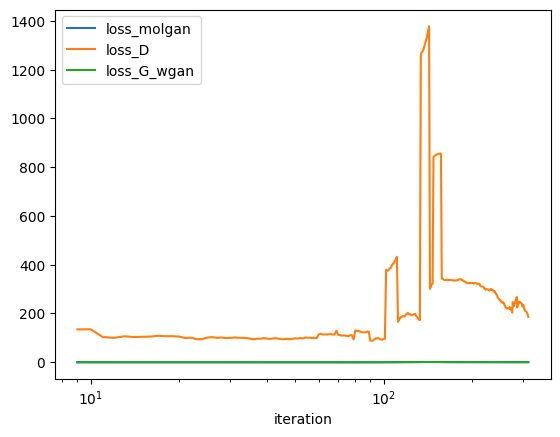

In [40]:
result_df=pd.DataFrame(result,index=["loss_molgan", "loss_V", "loss_D", "loss_G_wgan", "loss_RL", "loss_sum"]).T
ax=result_df.drop(columns=['loss_sum','loss_V','loss_RL']).rolling(window=10).mean().plot()
ax.set_xscale('log')
#ax.set_ylim((-8,8))
ax.set_xlabel("iteration")

Text(0.5, 0, 'iteration')

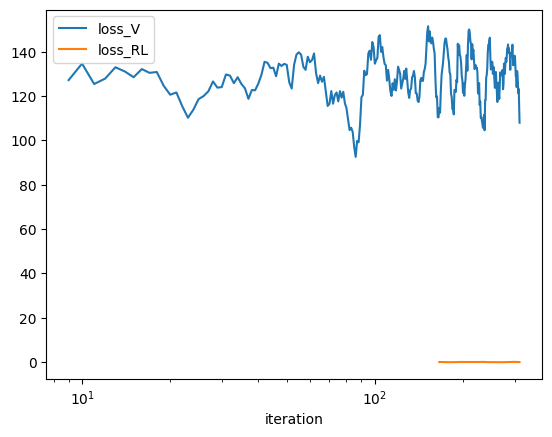

In [41]:
ax=result_df[['loss_V','loss_RL']].rolling(window=10).mean().plot()
ax.set_xscale('log')
#ax.set_ylim((-.6,.3))
ax.set_xlabel("iteration")

In [45]:
torch.__version__

'2.2.2'

Text(0.5, 1.0, 'loss_molgan')

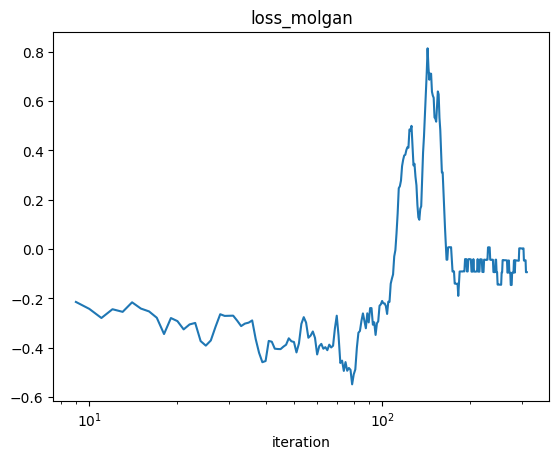

In [42]:
ax=result_df['loss_molgan'].rolling(window=10).mean().plot()
ax.set_xscale('log')
#ax.set_ylim((-10,10))
ax.set_xlabel("iteration")
ax.set_title("loss_molgan")

Text(0.5, 0, 'iteration')

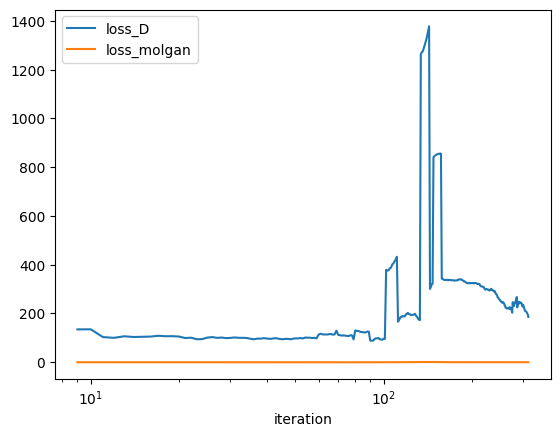

In [43]:
ax=result_df[['loss_D','loss_molgan']].rolling(window=10).mean().plot()
ax.set_xscale('log')
#ax.set_ylim((-.6,.3))
ax.set_xlabel("iteration")

In [ ]:
GP_LAMBDA

In [27]:
with torch.no_grad():
    tmp=tqdm(range(10000))
    for _ in tmp:
        generated=solver.G(sample(Z_DIM))
        sampled_graph=sample_gumbel(*generated,hard=True)
        tmpmol=(mol_from_graph(*sampled_graph,print_errors=False))
        tmp.set_description(f'{sampled_graph[1][...,1:,:,:].sum()}')
        if tmpmol is not None:
            display(tmpmol)

60.0:   0%|                                                                                  | 0/10000 [00:00<?, ?it/s]

[None]

62.0:   0%|                                                                                  | 0/10000 [00:00<?, ?it/s]

[None]

59.0:   0%|                                                                                  | 0/10000 [00:00<?, ?it/s]

[None]

66.0:   0%|                                                                                  | 0/10000 [00:00<?, ?it/s]

[None]

64.0:   0%|                                                                                  | 0/10000 [00:00<?, ?it/s]

[None]

53.0:   0%|                                                                                  | 0/10000 [00:00<?, ?it/s]

[None]

59.0:   0%|                                                                                  | 0/10000 [00:00<?, ?it/s]

[None]

54.0:   0%|                                                                          | 7/10000 [00:00<02:30, 66.32it/s]

[None]

64.0:   0%|                                                                          | 7/10000 [00:00<02:30, 66.32it/s]

[None]

61.0:   0%|                                                                          | 7/10000 [00:00<02:30, 66.32it/s]

[None]

64.0:   0%|                                                                          | 7/10000 [00:00<02:30, 66.32it/s]

[None]

55.0:   0%|                                                                          | 7/10000 [00:00<02:30, 66.32it/s]

[None]

53.0:   0%|                                                                          | 7/10000 [00:00<02:30, 66.32it/s]

[None]

67.0:   0%|                                                                          | 7/10000 [00:00<02:30, 66.32it/s]

[None]

57.0:   0%|                                                                          | 7/10000 [00:00<02:30, 66.32it/s]

[None]

61.0:   0%|                                                                          | 7/10000 [00:00<02:30, 66.32it/s]

[None]

59.0:   0%|                                                                          | 7/10000 [00:00<02:30, 66.32it/s]

[None]

61.0:   0%|                                                                          | 7/10000 [00:00<02:30, 66.32it/s]

[None]

57.0:   0%|                                                                          | 7/10000 [00:00<02:30, 66.32it/s]

[None]

63.0:   0%|                                                                          | 7/10000 [00:00<02:30, 66.32it/s]

[None]

58.0:   0%|                                                                          | 7/10000 [00:00<02:30, 66.32it/s]

[None]

61.0:   0%|                                                                          | 7/10000 [00:00<02:30, 66.32it/s]

[None]

62.0:   0%|                                                                          | 7/10000 [00:00<02:30, 66.32it/s]

[None]

65.0:   0%|                                                                          | 7/10000 [00:00<02:30, 66.32it/s]

[None]

59.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

60.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

55.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

60.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

62.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

59.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

59.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

65.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

59.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

61.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

56.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

57.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

63.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

67.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

59.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

64.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

56.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

64.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

59.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

58.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

64.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

57.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

62.0:   0%|▏                                                                       | 24/10000 [00:00<01:20, 123.33it/s]

[None]

63.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

58.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

57.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

61.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

60.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

63.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

63.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

61.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

70.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

63.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

66.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

55.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

57.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

60.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

62.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

62.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

64.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

51.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

57.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

55.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

63.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

61.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

59.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

61.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

59.0:   0%|▎                                                                       | 47/10000 [00:00<00:58, 170.28it/s]

[None]

67.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

68.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

60.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

61.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

59.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

64.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

66.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

67.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

61.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

60.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

60.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

61.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

59.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

59.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

54.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

60.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

58.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

61.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

58.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

64.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

60.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

56.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

63.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

55.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

54.0:   1%|▌                                                                       | 72/10000 [00:00<00:50, 198.44it/s]

[None]

61.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

62.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

63.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

55.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

56.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

64.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

59.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

60.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

64.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

56.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

56.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

61.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

59.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

66.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

64.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

66.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

66.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

61.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

56.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

64.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

57.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

68.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

56.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

57.0:   1%|▋                                                                       | 97/10000 [00:00<00:46, 214.74it/s]

[None]

68.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

64.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

64.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

65.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

58.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

60.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

61.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

60.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

66.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

61.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

61.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

62.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

64.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

65.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

53.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

57.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

62.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

65.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

64.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

55.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

67.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

58.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

55.0:   1%|▊                                                                      | 121/10000 [00:00<00:44, 222.14it/s]

[None]

70.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

62.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

53.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

65.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

65.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

61.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

63.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

63.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

64.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

64.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

66.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

58.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

56.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

58.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

64.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

56.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

65.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

64.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

68.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

55.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

61.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

62.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

58.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

62.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

59.0:   1%|█                                                                      | 144/10000 [00:00<00:44, 221.68it/s]

[None]

60.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

56.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

60.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

53.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

60.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

48.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

57.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

58.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

62.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

64.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

60.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

59.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

60.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

64.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

55.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

62.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

71.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

62.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

60.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

62.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

60.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

62.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

58.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

58.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

58.0:   2%|█▏                                                                     | 169/10000 [00:00<00:43, 228.53it/s]

[None]

67.0:   2%|█▍                                                                     | 194/10000 [00:00<00:41, 233.73it/s]

[None]

61.0:   2%|█▍                                                                     | 194/10000 [00:00<00:41, 233.73it/s]

[None]

62.0:   2%|█▍                                                                     | 194/10000 [00:00<00:41, 233.73it/s]

[None]

59.0:   2%|█▍                                                                     | 194/10000 [00:00<00:41, 233.73it/s]

[None]

62.0:   2%|█▍                                                                     | 194/10000 [00:00<00:41, 233.73it/s]

[None]

66.0:   2%|█▍                                                                     | 194/10000 [00:00<00:41, 233.73it/s]

[None]

61.0:   2%|█▍                                                                     | 194/10000 [00:00<00:41, 233.73it/s]

[None]

64.0:   2%|█▍                                                                     | 194/10000 [00:00<00:41, 233.73it/s]

[None]

68.0:   2%|█▍                                                                     | 194/10000 [00:00<00:41, 233.73it/s]

[None]

62.0:   2%|█▍                                                                     | 194/10000 [00:00<00:41, 233.73it/s]

[None]

60.0:   2%|█▍                                                                     | 194/10000 [00:00<00:41, 233.73it/s]

[None]

62.0:   2%|█▍                                                                     | 194/10000 [00:00<00:41, 233.73it/s]

[None]

63.0:   2%|█▍                                                                     | 194/10000 [00:00<00:41, 233.73it/s]

[None]

61.0:   2%|█▍                                                                     | 194/10000 [00:00<00:41, 233.73it/s]

[None]

60.0:   2%|█▍                                                                     | 194/10000 [00:00<00:41, 233.73it/s]

[None]

57.0:   2%|█▍                                                                     | 194/10000 [00:00<00:41, 233.73it/s]

[None]

58.0:   2%|█▍                                                                     | 194/10000 [00:00<00:41, 233.73it/s]

[None]

64.0:   2%|█▍                                                                     | 194/10000 [00:00<00:41, 233.73it/s]

[None]

61.0:   2%|█▍                                                                     | 194/10000 [00:01<00:41, 233.73it/s]

[None]

59.0:   2%|█▍                                                                     | 194/10000 [00:01<00:41, 233.73it/s]

[None]

64.0:   2%|█▍                                                                     | 194/10000 [00:01<00:41, 233.73it/s]

[None]

62.0:   2%|█▍                                                                     | 194/10000 [00:01<00:41, 233.73it/s]

[None]

65.0:   2%|█▍                                                                     | 194/10000 [00:01<00:41, 233.73it/s]

[None]

67.0:   2%|█▍                                                                     | 194/10000 [00:01<00:41, 233.73it/s]

[None]

57.0:   2%|█▍                                                                     | 194/10000 [00:01<00:41, 233.73it/s]

[None]

57.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

61.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

57.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

67.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

52.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

53.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

61.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

65.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

61.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

61.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

61.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

67.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

56.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

63.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

61.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

55.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

56.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

66.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

66.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

57.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

52.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

66.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

59.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

62.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

56.0:   2%|█▌                                                                     | 219/10000 [00:01<00:41, 236.24it/s]

[None]

61.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

58.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

65.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

68.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

63.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

66.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

62.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

61.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

60.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

61.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

63.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

53.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

65.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

58.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

63.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

60.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

60.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

53.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

57.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

63.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

56.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

59.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

68.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

53.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

67.0:   2%|█▋                                                                     | 244/10000 [00:01<00:41, 237.61it/s]

[None]

58.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

68.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

55.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

64.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

59.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

67.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

59.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

55.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

55.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

54.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

61.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

63.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

58.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

63.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

71.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

63.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

64.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

63.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

55.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

62.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

58.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

60.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

58.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

66.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

60.0:   3%|█▉                                                                     | 269/10000 [00:01<00:40, 240.11it/s]

[None]

62.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

57.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

62.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

67.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

61.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

64.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

65.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

60.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

69.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

60.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

63.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

60.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

63.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

68.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

63.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

65.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

56.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

59.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

57.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

57.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

62.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

62.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

57.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

60.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

54.0:   3%|██                                                                     | 294/10000 [00:01<00:39, 242.85it/s]

[None]

56.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

63.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

61.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

59.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

64.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

65.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

56.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

58.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

66.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

55.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

63.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

51.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

70.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

64.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

64.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

58.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

66.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

64.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

60.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

60.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

64.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

60.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

62.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

59.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

61.0:   3%|██▎                                                                    | 319/10000 [00:01<00:39, 244.68it/s]

[None]

64.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

62.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

60.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

59.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

53.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

69.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

55.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

65.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

58.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

61.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

59.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

57.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

69.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

59.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

61.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

60.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

60.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

55.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

58.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

64.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

65.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

67.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

61.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

57.0:   3%|██▍                                                                    | 344/10000 [00:01<00:40, 238.66it/s]

[None]

61.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

62.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

64.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

61.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

59.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

63.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

54.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

62.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

62.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

60.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

60.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

66.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

65.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

61.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

65.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

59.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

60.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

66.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

65.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

65.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

66.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

63.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

65.0:   4%|██▌                                                                    | 368/10000 [00:01<00:42, 228.83it/s]

[None]

65.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

59.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

64.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

61.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

62.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

59.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

65.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

61.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

66.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

59.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

65.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

67.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

60.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

53.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

63.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

67.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

61.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

62.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

66.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

64.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

53.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

57.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

63.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

53.0:   4%|██▊                                                                    | 391/10000 [00:01<00:42, 228.13it/s]

[None]

55.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

55.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

59.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

62.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

64.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

66.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

68.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

64.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

54.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

61.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

57.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

65.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

60.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

58.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

57.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

61.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

63.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

62.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

58.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

66.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

68.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

59.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

64.0:   4%|██▉                                                                    | 415/10000 [00:01<00:41, 229.03it/s]

[None]

62.0:   4%|███                                                                    | 438/10000 [00:01<00:43, 219.02it/s]

[None]

62.0:   4%|███                                                                    | 438/10000 [00:01<00:43, 219.02it/s]

[None]

69.0:   4%|███                                                                    | 438/10000 [00:01<00:43, 219.02it/s]

[None]

64.0:   4%|███                                                                    | 438/10000 [00:02<00:43, 219.02it/s]

[None]

60.0:   4%|███                                                                    | 438/10000 [00:02<00:43, 219.02it/s]

[None]

60.0:   4%|███                                                                    | 438/10000 [00:02<00:43, 219.02it/s]

[None]

61.0:   4%|███                                                                    | 438/10000 [00:02<00:43, 219.02it/s]

[None]

61.0:   4%|███                                                                    | 438/10000 [00:02<00:43, 219.02it/s]

[None]

61.0:   4%|███                                                                    | 438/10000 [00:02<00:43, 219.02it/s]

[None]

59.0:   4%|███                                                                    | 438/10000 [00:02<00:43, 219.02it/s]

[None]

63.0:   4%|███                                                                    | 438/10000 [00:02<00:43, 219.02it/s]

[None]

60.0:   4%|███                                                                    | 438/10000 [00:02<00:43, 219.02it/s]

[None]

60.0:   4%|███                                                                    | 438/10000 [00:02<00:43, 219.02it/s]

[None]

61.0:   4%|███                                                                    | 438/10000 [00:02<00:43, 219.02it/s]

[None]

59.0:   4%|███                                                                    | 438/10000 [00:02<00:43, 219.02it/s]

[None]

60.0:   4%|███                                                                    | 438/10000 [00:02<00:43, 219.02it/s]

[None]

63.0:   4%|███                                                                    | 438/10000 [00:02<00:43, 219.02it/s]

[None]

59.0:   4%|███                                                                    | 438/10000 [00:02<00:43, 219.02it/s]

[None]

64.0:   4%|███                                                                    | 438/10000 [00:02<00:43, 219.02it/s]

[None]

61.0:   4%|███                                                                    | 438/10000 [00:02<00:43, 219.02it/s]

[None]

57.0:   4%|███                                                                    | 438/10000 [00:02<00:43, 219.02it/s]

[None]

62.0:   4%|███                                                                    | 438/10000 [00:02<00:43, 219.02it/s]

[None]

65.0:   4%|███                                                                    | 438/10000 [00:02<00:43, 219.02it/s]

[None]

54.0:   4%|███                                                                    | 438/10000 [00:02<00:43, 219.02it/s]

[None]

58.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

64.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

58.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

64.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

65.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

64.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

64.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

61.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

54.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

62.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

70.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

55.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

64.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

69.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

72.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

59.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

63.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

57.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

66.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

58.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

57.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

70.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

65.0:   5%|███▎                                                                   | 462/10000 [00:02<00:42, 223.69it/s]

[None]

59.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

60.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

59.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

62.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

59.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

62.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

63.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

58.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

60.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

58.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

65.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

65.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

65.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

62.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

58.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

66.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

60.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

59.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

59.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

61.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

60.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

57.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

63.0:   5%|███▍                                                                   | 485/10000 [00:02<00:42, 225.03it/s]

[None]

58.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

63.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

64.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

63.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

60.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

56.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

63.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

56.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

62.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

59.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

71.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

61.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

69.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

65.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

63.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

65.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

62.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

63.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

57.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

64.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

65.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

63.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

56.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

64.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

62.0:   5%|███▌                                                                   | 508/10000 [00:02<00:43, 220.18it/s]

[None]

64.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

59.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

63.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

61.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

68.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

54.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

62.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

57.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

66.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

57.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

64.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

65.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

63.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

67.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

69.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

60.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

63.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

62.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

63.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

57.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

58.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

68.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

62.0:   5%|███▊                                                                   | 533/10000 [00:02<00:41, 227.08it/s]

[None]

57.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

65.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

61.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

54.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

63.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

62.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

60.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

68.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

58.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

57.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

70.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

61.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

60.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

60.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

64.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

56.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

62.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

52.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

63.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

57.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

55.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

53.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

63.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

60.0:   6%|███▉                                                                   | 556/10000 [00:02<00:41, 227.87it/s]

[None]

62.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

56.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

64.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

61.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

63.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

52.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

58.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

63.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

59.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

60.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

65.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

61.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

61.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

60.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

62.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

57.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

63.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

59.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

64.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

61.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

60.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

65.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

64.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

59.0:   6%|████                                                                   | 580/10000 [00:02<00:40, 230.32it/s]

[None]

66.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

63.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

58.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

58.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

61.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

63.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

63.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

66.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

64.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

55.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

68.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

63.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

60.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

61.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

66.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

61.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

63.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

61.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

69.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

59.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

64.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

54.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

66.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

67.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

65.0:   6%|████▎                                                                  | 604/10000 [00:02<00:40, 229.39it/s]

[None]

61.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

61.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

67.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

69.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

48.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

64.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

63.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

56.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

61.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

59.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

63.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

61.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

57.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

61.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

65.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

58.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

62.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

64.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

54.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

59.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

59.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

55.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

65.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

59.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

65.0:   6%|████▍                                                                  | 629/10000 [00:02<00:40, 232.65it/s]

[None]

67.0:   7%|████▋                                                                  | 654/10000 [00:02<00:39, 234.12it/s]

[None]

66.0:   7%|████▋                                                                  | 654/10000 [00:02<00:39, 234.12it/s]

[None]

66.0:   7%|████▋                                                                  | 654/10000 [00:02<00:39, 234.12it/s]

[None]

65.0:   7%|████▋                                                                  | 654/10000 [00:02<00:39, 234.12it/s]

[None]

64.0:   7%|████▋                                                                  | 654/10000 [00:02<00:39, 234.12it/s]

[None]

59.0:   7%|████▋                                                                  | 654/10000 [00:02<00:39, 234.12it/s]

[None]

66.0:   7%|████▋                                                                  | 654/10000 [00:02<00:39, 234.12it/s]

[None]

60.0:   7%|████▋                                                                  | 654/10000 [00:02<00:39, 234.12it/s]

[None]

65.0:   7%|████▋                                                                  | 654/10000 [00:02<00:39, 234.12it/s]

[None]

59.0:   7%|████▋                                                                  | 654/10000 [00:02<00:39, 234.12it/s]

[None]

55.0:   7%|████▋                                                                  | 654/10000 [00:02<00:39, 234.12it/s]

[None]

62.0:   7%|████▋                                                                  | 654/10000 [00:02<00:39, 234.12it/s]

[None]

65.0:   7%|████▋                                                                  | 654/10000 [00:02<00:39, 234.12it/s]

[None]

62.0:   7%|████▋                                                                  | 654/10000 [00:02<00:39, 234.12it/s]

[None]

56.0:   7%|████▋                                                                  | 654/10000 [00:02<00:39, 234.12it/s]

[None]

65.0:   7%|████▋                                                                  | 654/10000 [00:02<00:39, 234.12it/s]

[None]

68.0:   7%|████▋                                                                  | 654/10000 [00:02<00:39, 234.12it/s]

[None]

59.0:   7%|████▋                                                                  | 654/10000 [00:02<00:39, 234.12it/s]

[None]

63.0:   7%|████▋                                                                  | 654/10000 [00:02<00:39, 234.12it/s]

[None]

59.0:   7%|████▋                                                                  | 654/10000 [00:02<00:39, 234.12it/s]

[None]

65.0:   7%|████▋                                                                  | 654/10000 [00:02<00:39, 234.12it/s]

[None]

59.0:   7%|████▋                                                                  | 654/10000 [00:03<00:39, 234.12it/s]

[None]

61.0:   7%|████▋                                                                  | 654/10000 [00:03<00:39, 234.12it/s]

[None]

61.0:   7%|████▋                                                                  | 654/10000 [00:03<00:39, 234.12it/s]

[None]

64.0:   7%|████▋                                                                  | 654/10000 [00:03<00:39, 234.12it/s]

[None]

55.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

55.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

64.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

63.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

63.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

64.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

58.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

63.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

61.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

57.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

62.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

61.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

66.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

61.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

62.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

58.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

56.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

60.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

60.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

65.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

63.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

62.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

57.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

62.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

63.0:   7%|████▊                                                                  | 679/10000 [00:03<00:39, 238.04it/s]

[None]

61.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

66.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

57.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

61.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

70.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

64.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

66.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

63.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

59.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

70.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

67.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

51.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

65.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

63.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

62.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

59.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

60.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

60.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

63.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

56.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

62.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

64.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

61.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

56.0:   7%|████▉                                                                  | 704/10000 [00:03<00:38, 238.71it/s]

[None]

56.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

60.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

64.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

56.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

66.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

62.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

60.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

67.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

60.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

62.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

65.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

63.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

60.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

56.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

63.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

66.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

62.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

60.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

59.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

56.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

56.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

59.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

67.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

61.0:   7%|█████▏                                                                 | 728/10000 [00:03<00:38, 238.84it/s]

[None]

53.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

57.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

63.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

63.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

64.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

62.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

54.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

65.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

63.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

58.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

61.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

60.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

61.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

61.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

59.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

60.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

60.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

56.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

63.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

62.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

55.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

66.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

62.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

57.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

63.0:   8%|█████▎                                                                 | 752/10000 [00:03<00:39, 235.47it/s]

[None]

58.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

66.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

48.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

61.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

59.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

70.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

65.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

62.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

61.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

56.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

55.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

63.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

65.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

64.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

66.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

60.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

59.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

66.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

58.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

59.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

57.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

62.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

61.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

57.0:   8%|█████▌                                                                 | 777/10000 [00:03<00:38, 237.39it/s]

[None]

65.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

60.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

57.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

67.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

56.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

59.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

61.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

62.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

63.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

59.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

58.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

62.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

60.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

58.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

64.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

63.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

59.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

60.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

67.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

66.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

57.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

58.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

61.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

65.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

65.0:   8%|█████▋                                                                 | 801/10000 [00:03<00:39, 235.51it/s]

[None]

52.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

64.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

56.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

60.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

58.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

60.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

52.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

58.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

55.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

63.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

64.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

59.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

61.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

60.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

58.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

61.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

67.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

60.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

65.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

56.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

59.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

59.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

63.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

61.0:   8%|█████▊                                                                 | 826/10000 [00:03<00:38, 236.75it/s]

[None]

61.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

60.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

62.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

59.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

66.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

59.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

64.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

63.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

66.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

59.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

65.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

59.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

53.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

59.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

63.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

61.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

61.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

58.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

62.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

71.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

51.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

55.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

62.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

56.0:   8%|██████                                                                 | 850/10000 [00:03<00:38, 236.35it/s]

[None]

60.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

58.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

60.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

59.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

62.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

58.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

66.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

56.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

58.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

59.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

64.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

62.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

58.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

61.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

60.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

64.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

58.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

55.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

66.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

57.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

61.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

65.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

67.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

63.0:   9%|██████▏                                                                | 874/10000 [00:03<00:38, 236.77it/s]

[None]

61.0:   9%|██████▍                                                                | 898/10000 [00:03<00:40, 224.26it/s]

[None]

57.0:   9%|██████▍                                                                | 898/10000 [00:03<00:40, 224.26it/s]

[None]

56.0:   9%|██████▍                                                                | 898/10000 [00:03<00:40, 224.26it/s]

[None]

68.0:   9%|██████▍                                                                | 898/10000 [00:03<00:40, 224.26it/s]

[None]

62.0:   9%|██████▍                                                                | 898/10000 [00:03<00:40, 224.26it/s]

[None]

59.0:   9%|██████▍                                                                | 898/10000 [00:03<00:40, 224.26it/s]

[None]

59.0:   9%|██████▍                                                                | 898/10000 [00:03<00:40, 224.26it/s]

[None]

65.0:   9%|██████▍                                                                | 898/10000 [00:03<00:40, 224.26it/s]

[None]

60.0:   9%|██████▍                                                                | 898/10000 [00:04<00:40, 224.26it/s]

[None]

58.0:   9%|██████▍                                                                | 898/10000 [00:04<00:40, 224.26it/s]

[None]

69.0:   9%|██████▍                                                                | 898/10000 [00:04<00:40, 224.26it/s]

[None]

53.0:   9%|██████▍                                                                | 898/10000 [00:04<00:40, 224.26it/s]

[None]

62.0:   9%|██████▍                                                                | 898/10000 [00:04<00:40, 224.26it/s]

[None]

65.0:   9%|██████▍                                                                | 898/10000 [00:04<00:40, 224.26it/s]

[None]

64.0:   9%|██████▍                                                                | 898/10000 [00:04<00:40, 224.26it/s]

[None]

55.0:   9%|██████▍                                                                | 898/10000 [00:04<00:40, 224.26it/s]

[None]

65.0:   9%|██████▍                                                                | 898/10000 [00:04<00:40, 224.26it/s]

[None]

67.0:   9%|██████▍                                                                | 898/10000 [00:04<00:40, 224.26it/s]

[None]

56.0:   9%|██████▍                                                                | 898/10000 [00:04<00:40, 224.26it/s]

[None]

62.0:   9%|██████▍                                                                | 898/10000 [00:04<00:40, 224.26it/s]

[None]

63.0:   9%|██████▍                                                                | 898/10000 [00:04<00:40, 224.26it/s]

[None]

64.0:   9%|██████▍                                                                | 898/10000 [00:04<00:40, 224.26it/s]

[None]

61.0:   9%|██████▍                                                                | 898/10000 [00:04<00:40, 224.26it/s]

[None]

63.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

61.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

55.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

57.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

60.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

63.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

60.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

66.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

61.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

63.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

72.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

66.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

59.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

55.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

65.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

61.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

62.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

62.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

58.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

62.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

61.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

57.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

62.0:   9%|██████▌                                                                | 921/10000 [00:04<00:40, 222.48it/s]

[None]

65.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

62.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

58.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

62.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

69.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

71.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

60.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

64.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

61.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

61.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

59.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

58.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

58.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

65.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

59.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

65.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

64.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

55.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

59.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

52.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

56.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

61.0:   9%|██████▋                                                                | 944/10000 [00:04<00:42, 214.24it/s]

[None]

59.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

64.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

59.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

58.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

63.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

65.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

58.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

63.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

67.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

61.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

64.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

59.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

58.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

61.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

63.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

61.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

61.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

57.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

63.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

63.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

56.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

66.0:  10%|██████▊                                                                | 966/10000 [00:04<00:42, 214.15it/s]

[None]

58.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

59.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

62.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

59.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

64.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

68.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

60.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

65.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

69.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

58.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

67.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

67.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

61.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

63.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

57.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

55.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

61.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

64.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

60.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

61.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

65.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

55.0:  10%|███████                                                                | 988/10000 [00:04<00:42, 213.53it/s]

[None]

62.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

57.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

58.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

60.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

60.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

62.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

59.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

63.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

61.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

64.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

63.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

65.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

65.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

55.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

53.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

65.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

70.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

52.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

58.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

63.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

52.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

59.0:  10%|███████                                                               | 1010/10000 [00:04<00:42, 210.80it/s]

[None]

57.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

60.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

58.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

66.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

58.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

59.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

63.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

60.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

57.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

55.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

60.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

59.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

61.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

61.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

70.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

59.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

61.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

65.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

60.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

59.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

62.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

64.0:  10%|███████▏                                                              | 1032/10000 [00:04<00:42, 212.62it/s]

[None]

61.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

64.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

62.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

62.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

64.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

53.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

63.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

63.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

59.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

53.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

60.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

63.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

64.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

52.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

56.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

60.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

59.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

58.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

59.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

56.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

55.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

60.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

63.0:  11%|███████▍                                                              | 1054/10000 [00:04<00:43, 207.61it/s]

[None]

58.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

60.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

65.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

70.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

51.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

62.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

61.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

61.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

67.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

57.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

63.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

61.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

60.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

64.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

68.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

67.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

54.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

60.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

60.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

60.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

65.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

61.0:  11%|███████▌                                                              | 1077/10000 [00:04<00:42, 211.38it/s]

[None]

64.0:  11%|███████▋                                                              | 1099/10000 [00:04<00:42, 211.53it/s]

[None]

63.0:  11%|███████▋                                                              | 1099/10000 [00:04<00:42, 211.53it/s]

[None]

60.0:  11%|███████▋                                                              | 1099/10000 [00:04<00:42, 211.53it/s]

[None]

65.0:  11%|███████▋                                                              | 1099/10000 [00:04<00:42, 211.53it/s]

[None]

64.0:  11%|███████▋                                                              | 1099/10000 [00:04<00:42, 211.53it/s]

[None]

66.0:  11%|███████▋                                                              | 1099/10000 [00:04<00:42, 211.53it/s]

[None]

64.0:  11%|███████▋                                                              | 1099/10000 [00:04<00:42, 211.53it/s]

[None]

64.0:  11%|███████▋                                                              | 1099/10000 [00:04<00:42, 211.53it/s]

[None]

59.0:  11%|███████▋                                                              | 1099/10000 [00:04<00:42, 211.53it/s]

[None]

57.0:  11%|███████▋                                                              | 1099/10000 [00:04<00:42, 211.53it/s]

[None]

59.0:  11%|███████▋                                                              | 1099/10000 [00:04<00:42, 211.53it/s]

[None]

63.0:  11%|███████▋                                                              | 1099/10000 [00:04<00:42, 211.53it/s]

[None]

62.0:  11%|███████▋                                                              | 1099/10000 [00:04<00:42, 211.53it/s]

[None]

62.0:  11%|███████▋                                                              | 1099/10000 [00:04<00:42, 211.53it/s]

[None]

64.0:  11%|███████▋                                                              | 1099/10000 [00:04<00:42, 211.53it/s]

[None]

58.0:  11%|███████▋                                                              | 1099/10000 [00:04<00:42, 211.53it/s]

[None]

64.0:  11%|███████▋                                                              | 1099/10000 [00:04<00:42, 211.53it/s]

[None]

62.0:  11%|███████▋                                                              | 1099/10000 [00:04<00:42, 211.53it/s]

[None]

68.0:  11%|███████▋                                                              | 1099/10000 [00:05<00:42, 211.53it/s]

[None]

56.0:  11%|███████▋                                                              | 1099/10000 [00:05<00:42, 211.53it/s]

[None]

62.0:  11%|███████▋                                                              | 1099/10000 [00:05<00:42, 211.53it/s]

[None]

63.0:  11%|███████▋                                                              | 1099/10000 [00:05<00:42, 211.53it/s]

[None]

58.0:  11%|███████▋                                                              | 1099/10000 [00:05<00:42, 211.53it/s]

[None]

59.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

59.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

65.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

67.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

63.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

64.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

63.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

67.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

60.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

58.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

66.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

59.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

60.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

63.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

67.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

55.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

62.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

58.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

62.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

65.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

60.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

64.0:  11%|███████▊                                                              | 1122/10000 [00:05<00:41, 214.59it/s]

[None]

64.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

60.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

62.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

61.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

58.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

64.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

59.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

60.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

64.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

54.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

62.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

59.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

56.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

58.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

64.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

64.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

60.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

69.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

57.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

60.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

63.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

57.0:  11%|████████                                                              | 1144/10000 [00:05<00:41, 212.92it/s]

[None]

63.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

59.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

54.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

57.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

58.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

63.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

62.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

53.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

66.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

63.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

66.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

67.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

59.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

62.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

58.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

57.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

55.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

61.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

62.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

58.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

62.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

58.0:  12%|████████▏                                                             | 1166/10000 [00:05<00:41, 212.63it/s]

[None]

60.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

57.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

60.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

60.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

58.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

61.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

64.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

56.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

57.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

65.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

58.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

62.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

57.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

63.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

58.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

59.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

58.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

69.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

65.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

58.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

64.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

57.0:  12%|████████▎                                                             | 1188/10000 [00:05<00:41, 213.64it/s]

[None]

57.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

64.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

68.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

64.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

65.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

60.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

65.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

56.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

62.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

55.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

61.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

62.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

58.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

59.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

60.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

61.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

63.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

56.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

62.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

54.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

62.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

53.0:  12%|████████▍                                                             | 1210/10000 [00:05<00:41, 212.12it/s]

[None]

58.0:  12%|████████▌                                                             | 1232/10000 [00:05<00:42, 208.54it/s]

[None]

57.0:  12%|████████▌                                                             | 1232/10000 [00:05<00:42, 208.54it/s]

[None]

58.0:  12%|████████▌                                                             | 1232/10000 [00:05<00:42, 208.54it/s]

[None]

67.0:  12%|████████▌                                                             | 1232/10000 [00:05<00:42, 208.54it/s]

[None]

58.0:  12%|████████▌                                                             | 1232/10000 [00:05<00:42, 208.54it/s]

[None]

65.0:  12%|████████▌                                                             | 1232/10000 [00:05<00:42, 208.54it/s]

[None]

58.0:  12%|████████▌                                                             | 1232/10000 [00:05<00:42, 208.54it/s]

[None]

55.0:  12%|████████▌                                                             | 1232/10000 [00:05<00:42, 208.54it/s]

[None]

67.0:  12%|████████▌                                                             | 1232/10000 [00:05<00:42, 208.54it/s]

[None]

60.0:  12%|████████▌                                                             | 1232/10000 [00:05<00:42, 208.54it/s]

[None]

58.0:  12%|████████▌                                                             | 1232/10000 [00:05<00:42, 208.54it/s]

[None]

62.0:  12%|████████▌                                                             | 1232/10000 [00:05<00:42, 208.54it/s]

[None]

62.0:  12%|████████▋                                                             | 1244/10000 [00:05<00:39, 221.83it/s]

KeyboardInterrupt



In [28]:
best_mol=None
best_score=-100
with torch.no_grad():
    tmp=tqdm(range(10000))
    for _ in tmp:
        generated=solver.G(sample(Z_DIM))
        sampled_graph=sample_gumbel(*generated,hard=True)
        try:
            tmp_score=reward(mol_from_graph(*sampled_graph,strict=False)).item()
        except:
            tmp_score=0
        if (tmp_score)>best_score:
            best_score=tmp_score
            best_mol=sampled_graph
            tmp.set_description(f'{best_score} {sampled_graph[1][...,1:,:,:].sum()}')
            #display(mol_from_graph(*best_mol,strict=False))

0 62.0: 100%|███████████████████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.00it/s]


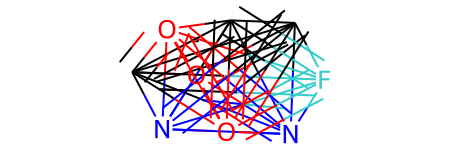

In [33]:
mol_from_graph(*best_mol,strict=False)[0]

In [ ]:
mol_from_graph(*sampled_graph,strict=False)

In [ ]:
mol_from_graph(*best_mol,strict=False)

In [ ]:
with torch.no_grad():
    print(solver.R(sampled_graph).item())

In [ ]:
from IPython.display import display
for generated_graph in zip(*generated):
    tmp=(sample_gumbel(*generated_graph))
    break

In [ ]:
mol_from_graph(*tmp,print_errors=True)

WGAN-GP formula

$\underset{G}{\min}\underset{D}{\max}{[D(x)-D(G(z))+\lambda(\nabla_\hat{x}||D(\hat{x})||_2-1)^2]};x\sim X;z\sim p(z)$